# **Onboarding Task**

In [1]:
# Load packages
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from xgboost import plot_importance
import shap

pd.set_option('display.max_columns', None)


In [2]:
# Define functions
def base_fare_hist(df: pd.DataFrame, min_value: np.int64, max_value: np.int64, ticks_by: np.float64):
    n, bins, patches = plt.hist(df[(min_value <= df['base_fare']) & (df['base_fare'] <= max_value)]['base_fare'], 
                                np.arange(min_value, max_value, ticks_by), 
                                color='lightblue', 
                                edgecolor='black')
    x_ticks = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
    plt.xticks(x_ticks)
    plt.tick_params(axis='x', rotation=90)
    
def agg_string_distinct(df, group, var, rename_var):
    return df.sort_values(by=[group, var]).groupby(group)[var].unique().str.join(',').reset_index().rename(columns={var: rename_var})

def min_max_time(df, group, var, rename_var, function_name):
    if function_name == 'min':
        return df.groupby(group)[var].min().reset_index().rename(columns={var: rename_var})
    elif function_name == 'max':
        return df.groupby(group)[var].max().reset_index().rename(columns={var: rename_var})
    else:
        raise ValueError("function_name should be 'min' or 'max'")
        
def objective(X, y, model, sampled=None, sampling_method=None):
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if sampled == 1:   
        X_train, y_train = sampling_method.fit_resample(X_train, y_train)

    model = model

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Use the SelectFromModel class to select important features
    selector = SelectFromModel(model, prefit=True)
    selected_feature_names = X_train.columns[selector.get_support()]

    X_train_selected = X_train[selected_feature_names]
    X_test_selected = X_test[selected_feature_names]

    model.fit(X_train_selected, y_train)

    y_probabilities = model.predict_proba(X_test_selected)[:, 1]  # Probability of the positive class
    auc = roc_auc_score(y_test, y_probabilities)

    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)

    return {'model': model, 'y_probabilities': y_probabilities, 'auc': auc, 'y_pred': y_pred, 
            'selected_feature_names': selected_feature_names, 'accuracy': accuracy,
           'precision': precision, 'recall': recall, 'f1': f1, 'conf_matrix': conf_matrix,
           'report': report, 'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

def feature_importances_graph(model):
    feature_importances = model.coef_[0]
    feature_names = X.columns

    feature_importance_dict = dict(zip(feature_names, feature_importances))
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

    # Sort the features by importance
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_feature_importance)), [item[1] for item in sorted_feature_importance])
    plt.yticks(range(len(sorted_feature_importance)), [item[0] for item in sorted_feature_importance])
    plt.xlabel("Feature Importance")
    plt.title(f"Top {len(sorted_feature_importance)} Feature Importances")
    plt.show()
    
def print_metrics(model):
    print(f"Accuracy: {model['accuracy']}")
    print(f"Precision: {model['precision']}")
    print(f"Recall: {model['recall']}")
    print(f"F1: {model['f1']}")
    print(f"AUC:\n{model['auc']}")
    print(f"Confusion Matrix:\n{model['conf_matrix']}")
    print(f"Classification Report:\n{model['report']}")
    

In [3]:
#  Load data
itineraries = pd.read_csv('itineraries.csv')
segments = pd.read_csv('segments.csv')


## **Data Exploration**

In [4]:
# itineraries[itineraries.duplicated()]

In [5]:
# itineraries_report = sv.analyze(itineraries)
# itineraries_report.show_html('Itineraries report.html')


In [6]:
# segments[segments.duplicated()]

In [7]:
# Drop duplicates from segments
segments.drop_duplicates(inplace=True)

In [8]:
# segments_report = sv.analyze(segments)
# segments_report.show_html('Segments report.html')

In [9]:
# Join itineraries and segmenst
data = itineraries.merge(segments, on='bid', how='outer').rename(columns={'src_x': 'src', 'dst_x': 'dst', 'src_y': 'route_src', 'dst_y': 'route_dst'})


In [10]:
# Inspect data 
data_report = sv.analyze(data)
data_report.show_html('Data report.html')

                                             |      | [  0%]   00:00 -> (? left)

Report Data report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [11]:
# Missing fare category
data[(data['fare_category'].isnull()) & (data['route_src'].notnull())].groupby('vehicle_type', dropna=False)['bid'].count()

vehicle_type
bus       736
train    1199
Name: bid, dtype: int64

In [12]:
data[data['vehicle_type'].isin(['bus', 'train'])].groupby('fare_category', dropna=False)['bid'].count()

fare_category
NaN    1935
Name: bid, dtype: int64

In [13]:
# Fill fare category for ground
data['fare_category'] = np.where((data['fare_category'].isnull()) & (data['vehicle_type']).isin(['bus', 'train']), 'ground', data['fare_category']) 

In [14]:
# Negative base fare???? 
itineraries[itineraries['base_fare'] < 0].groupby('bid')['bid'].count()

bid
171631581    1
Name: bid, dtype: int64

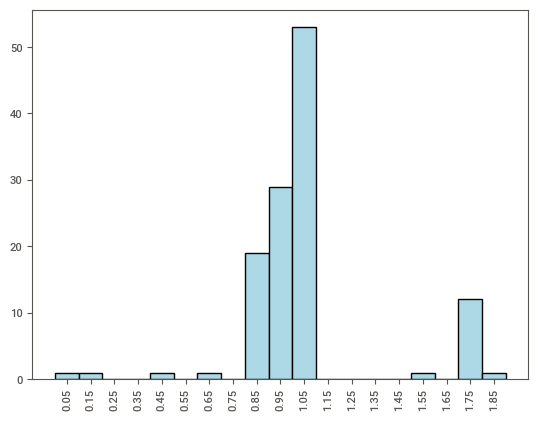

In [15]:
# Very low base fares????
base_fare_hist(itineraries, 0, 2, 0.1)

In [16]:
# base_fare_hist(data.dropna(subset=['src']).copy(), 0, 2, 0.1)

In [17]:
# Cross-check that trip types have correct number of sectors
data.groupby('trip_type')['sector'].max()

trip_type
multicity    8.0
nomad        6.0
oneway       1.0
roundtrip    2.0
Name: sector, dtype: float64

## **Create additional variables based on segments info**

In [18]:
data.sort_values(by=['bid', 'departure_time_utc'], inplace=True)

data['timestamp_of_search'] = pd.to_datetime(data['timestamp_of_search'])
data['departure_time_utc'] = pd.to_datetime(data['departure_time_utc'])
data['arrival_time_utc'] = pd.to_datetime(data['arrival_time_utc'])

# Create variables on segment level
data['next_departure_time_utc'] = data.groupby('bid')['departure_time_utc'].shift(-1)
data['next_sector'] = data.groupby('bid')['sector'].shift(-1)

data['layover'] = np.where(data['sector'] == data['next_sector'], 1, 0)
data['layover'] = np.where(data['sector'].isnull(), np.NaN, data['layover'])

data['flight_time'] = (data['arrival_time_utc'] - data['departure_time_utc']).dt.total_seconds() / 3600
data['layover_time'] = np.where(data['layover'] == 1, (data['next_departure_time_utc'] - data['arrival_time_utc']).dt.total_seconds() / 3600, np.NaN)
data['total_time'] = data['flight_time'] + data['layover_time'].fillna(0)

# Create variables on itinerary level
data = data.merge(agg_string_distinct(data, 'bid', 'airline', 'airline_combo'), on='bid', how='left')
data = data.merge(agg_string_distinct(data, 'bid', 'fare_category', 'fare_category_combo'), on='bid', how='left')
data = data.merge(agg_string_distinct(data, 'bid', 'vehicle_type', 'vehicle_type_combo'), on='bid', how='left')

data = data.merge(min_max_time(data, 'bid', 'flight_time', 'max_flight_time', 'max'), on='bid', how='left')
data = data.merge(min_max_time(data, 'bid', 'layover_time', 'min_layover_time', 'min'), on='bid', how='left')
data = data.merge(min_max_time(data, 'bid', 'departure_time_utc', 'min_departure_time_utc', 'min'), on='bid', how='left')
data['bw'] = (data['min_departure_time_utc'] - data['timestamp_of_search']).dt.days

data = data.merge(min_max_time(data[(data['trip_type'] == 'roundtrip') & (data['sector'] == 1)], 
                               'bid', 'arrival_time_utc', 'max_arrival_time_utc_s1', 'max'), on='bid', how='left')
data = data.merge(min_max_time(data[(data['trip_type'] == 'roundtrip') & (data['sector'] == 2)], 
                               'bid', 'departure_time_utc', 'min_departure_time_utc_s2', 'min'), on='bid', how='left')
data['rw'] = (data['min_departure_time_utc_s2'] - data['max_arrival_time_utc_s1']).dt.days

In [19]:
# Group variables back to itinerary level
data_fin = data.groupby(itineraries.keys().to_list() + 
                        ['airline_combo', 'fare_category_combo', 'vehicle_type_combo', 
                         'max_flight_time', 'min_layover_time', 'bw', 'rw'], dropna=False).agg(**{
    "n_segments":("bid", "count"),
    "n_layovers":("layover", "sum"),
    "total_flight_time":("flight_time", "sum"),
    "total_layover_time":("layover_time", "sum"),
    "total_travel_time":("total_time", "sum")}).reset_index()


# Create coded fare type for binary and multinomial models
data_fin["fare_type_multi"] = np.where(data_fin["fare_type"] == 'standard', 1, 2)
data_fin["fare_type_multi"] = np.where(data_fin["fare_type"] == 'saver', 1, data_fin["fare_type_multi"])
data_fin["fare_type_bin"] = np.where(data_fin["fare_type"] == 'standard', 1, 0)

# Create binary for return window applicability (1 for applicable, 0 for null or non-applicable)
data_fin['rw_applicable'] = np.where(data_fin['trip_type'] == 'roundtrip', 1, 0)
# Fill missing return window with -1 
data_fin['rw_filled'] = data_fin['rw'].fillna(-1)

In [20]:
# data_fin.keys()

In [21]:
# data_fin.head()

## **Models**

**Data highly imbalanced, using logistic/multinomial regression might not be the best approach.** \
**XGBoost should handle the imbalance data better in theory.** \
**Try under/over-sampling to increase models' performance.** \
**Conclusion: couldn't find any good-performing model.**
**Next steps: hyperparameter tuning, different classification thresholds, add/omit variables, ...**

In [22]:
# Sample highly imbalanced
data_fin.groupby("fare_type_bin")['bid'].count()

fare_type_bin
0    261279
1     16151
Name: bid, dtype: int64

In [23]:
# Ger rid of itineraries which don't have segmnts info available or which base fare is suspiciously low
data_model = data_fin[(data_fin['airline_combo'].notnull()) & (data_fin['base_fare'] >= 0.8)]

# Define dependent and target variables
dep_vars = data_model[['content_type', 'partner', 'trip_type', 'market', 'passengers', 'base_fare', 
                       'is_hold_bags_disabled', 'airline_combo', 'fare_category_combo', 'vehicle_type_combo', 
                       'bw', 'rw', 'n_segments', 'n_layovers', 'total_flight_time', 'total_layover_time', 
                       'rw_applicable', 'rw_filled']]

# Define categorical and continuous features
categorical_columns = ["content_type", "partner", 'trip_type', 'market', 'is_hold_bags_disabled', 
                       'airline_combo', 'fare_category_combo', 'vehicle_type_combo']
continuous_columns = ["passengers", 'base_fare', 'bw', 'rw', 'rw_filled', 'n_segments', 'n_layovers', 
                      'total_flight_time', 'total_layover_time']

In [24]:
# Select features and target
X = dep_vars.drop(columns=['rw', 'rw_applicable']) 
y = data_model["fare_type_bin"]

# Encode categorical variables
for col in list(set(X.keys().to_list()) & set(categorical_columns)):
    X[col] = LabelEncoder().fit_transform(X[col])

# Scale continuous variables
for col in list(set(X.keys().to_list()) & set(continuous_columns)):
    X[[col]] = StandardScaler().fit_transform(X[[col]])

### **Logistic regression models**

#### Model on original data - performing very poorly

In [25]:
# Model on original data
model = objective(X, y, LogisticRegression(random_state=42))

print_metrics(model)


Accuracy: 0.9403476669716377
Precision: 1.0
Recall: 0.0
F1: 0.0
AUC:
0.552070629744633
Confusion Matrix:
[[51390     0]
 [ 3260     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     51390
           1       1.00      0.00      0.00      3260

    accuracy                           0.94     54650
   macro avg       0.97      0.50      0.48     54650
weighted avg       0.94      0.94      0.91     54650



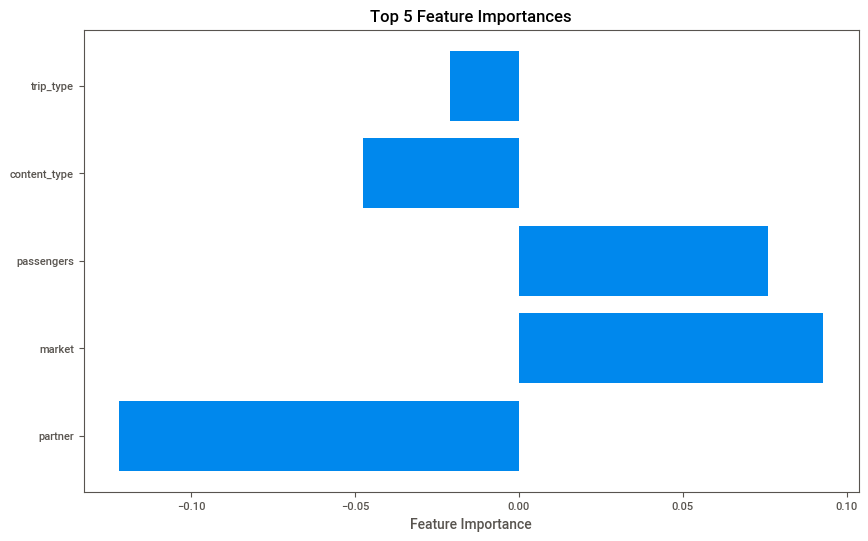

In [26]:
feature_importances_graph(model['model'])

#### Model on over-sampled data using SMOTE - performing very poorly

In [27]:
# Model with over-sampling
# Over-sampling the minority class using SMOTE
model_smote = objective(X, y, LogisticRegression(random_state=42), 
                        1, SMOTE(sampling_strategy='auto', random_state=42))

print_metrics(model_smote)


Accuracy: 0.47094236047575483
Precision: 0.0630556974961676
Recall: 0.5677914110429448
F1: 0.11350605549593745
AUC:
0.5330356130253792
Confusion Matrix:
[[23886 27504]
 [ 1409  1851]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.46      0.62     51390
           1       0.06      0.57      0.11      3260

    accuracy                           0.47     54650
   macro avg       0.50      0.52      0.37     54650
weighted avg       0.89      0.47      0.59     54650



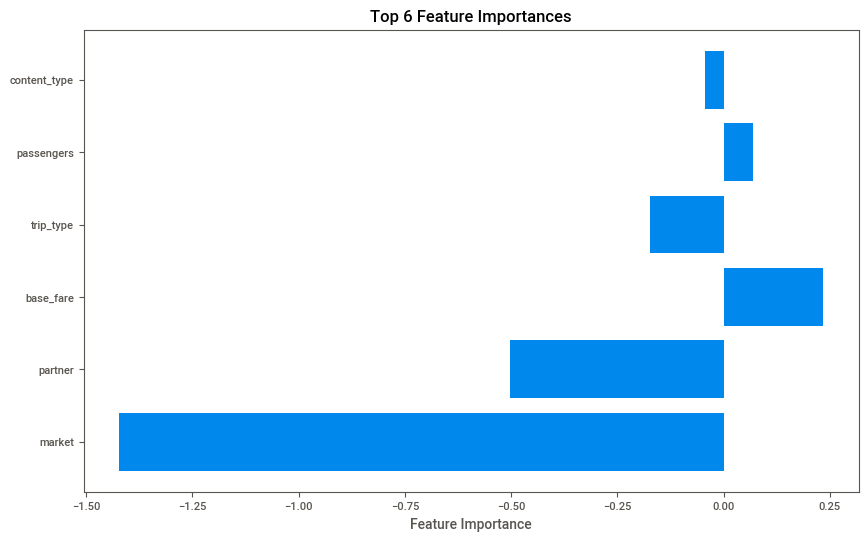

In [28]:
feature_importances_graph(model_smote['model'])

#### Model on under-sampled data using Tomek Links - performing very poorly

In [29]:
# Model with under-sampling
# Under-sampling the majority class using Tomek Links
model_tomek = objective(X, y, LogisticRegression(random_state=42),
                       1, TomekLinks(sampling_strategy='auto'))

print_metrics(model_tomek)

Accuracy: 0.9403476669716377
Precision: 1.0
Recall: 0.0
F1: 0.0
AUC:
0.5348945212658642
Confusion Matrix:
[[51390     0]
 [ 3260     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     51390
           1       1.00      0.00      0.00      3260

    accuracy                           0.94     54650
   macro avg       0.97      0.50      0.48     54650
weighted avg       0.94      0.94      0.91     54650



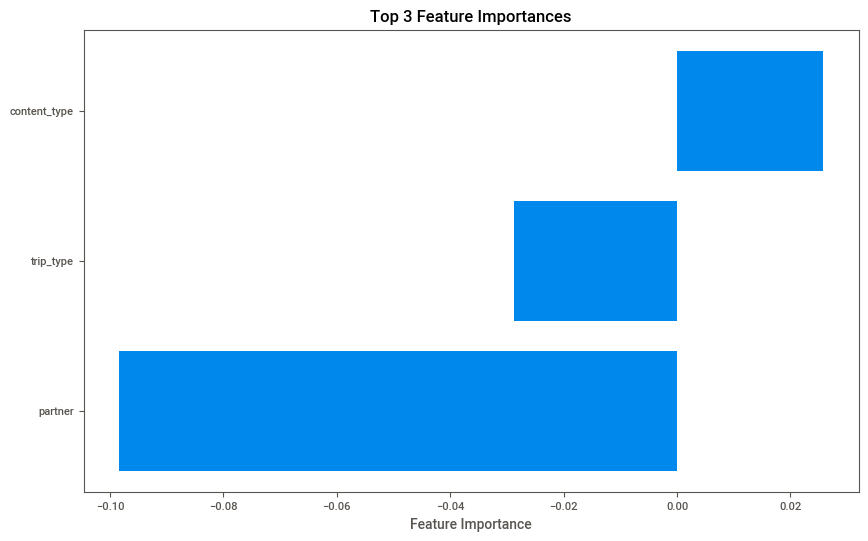

In [30]:
feature_importances_graph(model_tomek['model'])

#### Model on data sampled using a combination of SMOTE and Tomek Links - performing very poorly

In [31]:
# Combining SMOTE and Tomek Links (SMOTE-Tomek)
model_combi = objective(X, y, LogisticRegression(random_state=42),
                        1, SMOTETomek(sampling_strategy='auto', random_state=42))

print_metrics(model_combi)

Accuracy: 0.46384263494967976
Precision: 0.060222244739419735
Recall: 0.5469325153374233
F1: 0.1084978854169836
AUC:
0.525595915153816
Confusion Matrix:
[[23566 27824]
 [ 1477  1783]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.46      0.62     51390
           1       0.06      0.55      0.11      3260

    accuracy                           0.46     54650
   macro avg       0.50      0.50      0.36     54650
weighted avg       0.89      0.46      0.59     54650



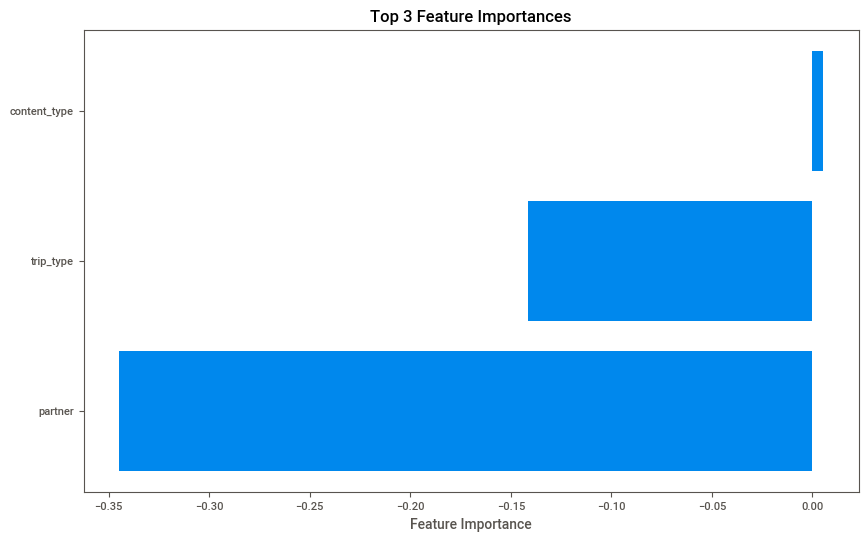

In [32]:
feature_importances_graph(model_combi['model'])

### **XGBoost models**

#### Model on original data - performing very poorly

In [33]:
# Model on original data
xgbmodel = objective(X, y, XGBClassifier(objective="binary:logistic",random_state=42))

print_metrics(xgbmodel)

Accuracy: 0.940256175663312
Precision: 0.2222222222222222
Recall: 0.0006134969325153375
F1: 0.0012236157846436222
AUC:
0.6237855052843826
Confusion Matrix:
[[51383     7]
 [ 3258     2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     51390
           1       0.22      0.00      0.00      3260

    accuracy                           0.94     54650
   macro avg       0.58      0.50      0.49     54650
weighted avg       0.90      0.94      0.91     54650



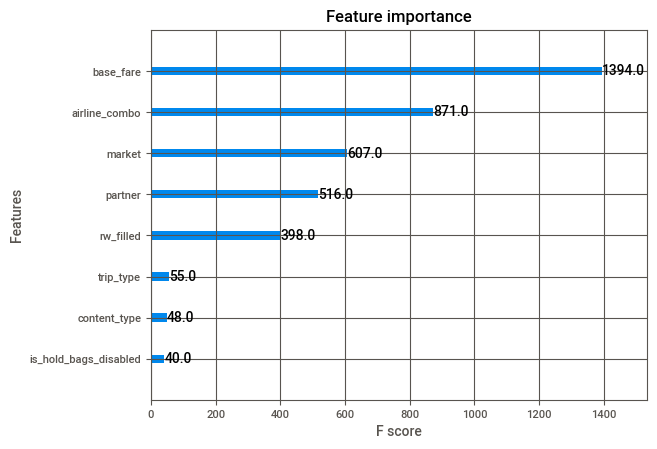

In [34]:
plot_importance(xgbmodel['model'])
plt.show()

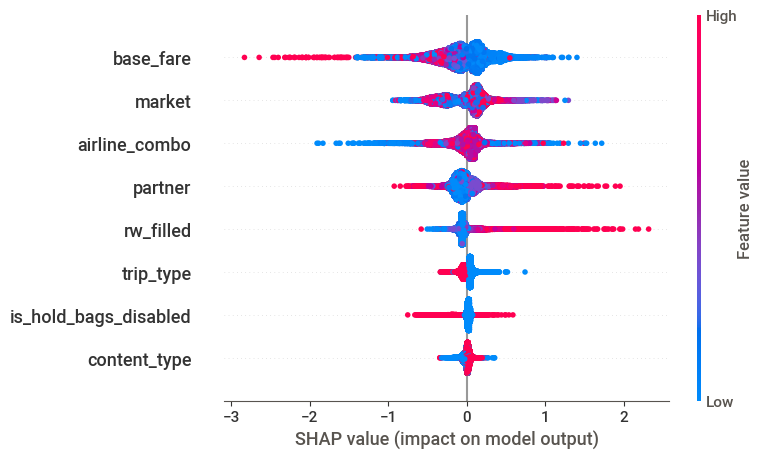

In [35]:
explainer = shap.TreeExplainer(xgbmodel['model'])
shap_values = explainer.shap_values(xgbmodel['X_test'][xgbmodel['selected_feature_names']])
shap.summary_plot(shap_values, xgbmodel['X_test'][xgbmodel['selected_feature_names']])

#### Model on over-sampled data using SMOTE - performing very poorly

In [36]:
# Model with over-sampling
# Over-sampling the minority class using SMOTE
xgbmodel_smote =  objective(X, y, XGBClassifier(objective="binary:logistic"),
                            1, SMOTE(sampling_strategy='auto', random_state=42))

print_metrics(xgbmodel_smote)

Accuracy: 0.940256175663312
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC:
0.5342582644208786
Confusion Matrix:
[[51385     5]
 [ 3260     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     51390
           1       0.00      0.00      0.00      3260

    accuracy                           0.94     54650
   macro avg       0.47      0.50      0.48     54650
weighted avg       0.88      0.94      0.91     54650



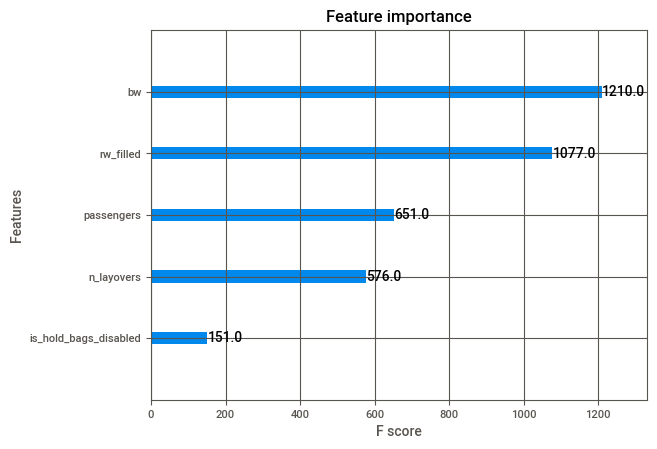

In [37]:
plot_importance(xgbmodel_smote['model'])
plt.show()

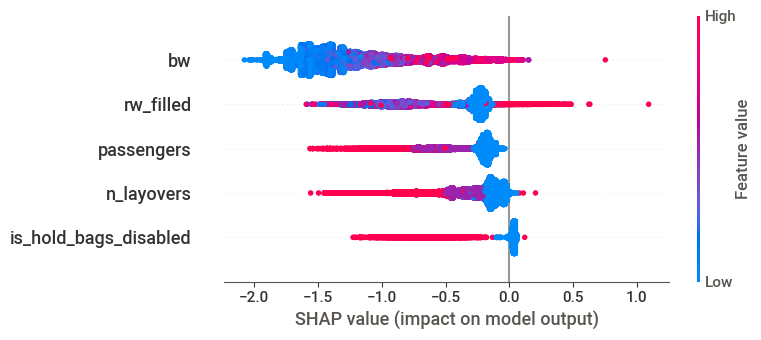

In [38]:
explainer = shap.TreeExplainer(xgbmodel_smote['model'])
shap_values = explainer.shap_values(xgbmodel_smote['X_test'][xgbmodel_smote['selected_feature_names']])
shap.summary_plot(shap_values, xgbmodel_smote['X_test'][xgbmodel_smote['selected_feature_names']])

#### Model on data sampled using a combination of SMOTE and Tomek Links - performing very poorly

In [39]:
# Combining SMOTE and Tomek Links (SMOTE-Tomek)
xgbmodel_combi = objective(X, y, XGBClassifier(objective="binary:logistic",random_state=42),
                           1, SMOTETomek(sampling_strategy='auto', random_state=42))

print_metrics(xgbmodel_combi)

Accuracy: 0.9403110704483074
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC:
0.5365007932841246
Confusion Matrix:
[[51388     2]
 [ 3260     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     51390
           1       0.00      0.00      0.00      3260

    accuracy                           0.94     54650
   macro avg       0.47      0.50      0.48     54650
weighted avg       0.88      0.94      0.91     54650



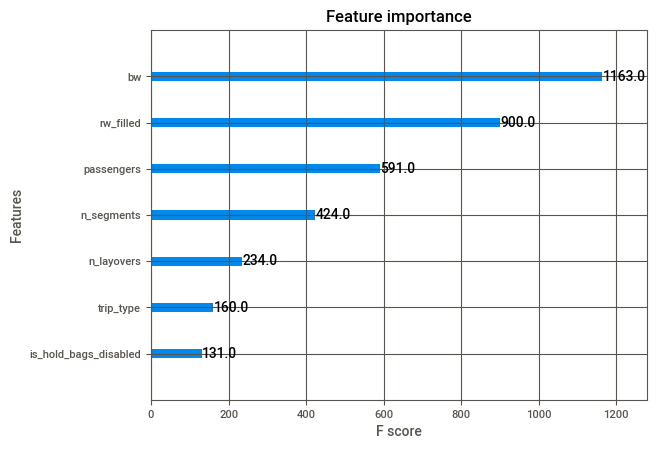

In [40]:
plot_importance(xgbmodel_combi['model'])
plt.show()

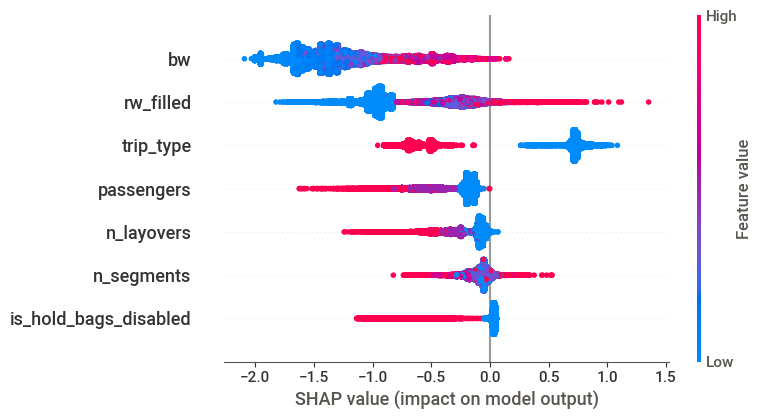

In [41]:
explainer = shap.TreeExplainer(xgbmodel_combi['model'])
shap_values = explainer.shap_values(xgbmodel_combi['X_test'][xgbmodel_combi['selected_feature_names']])
shap.summary_plot(shap_values, xgbmodel_combi['X_test'][xgbmodel_combi['selected_feature_names']])

#### Include hyperparameter tuning to the process - testing only 5 iterations

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

# Create an objective function for Hyperopt
def objective_func(params):
    clf = XGBClassifier(
        objective="binary:logistic",
        random_state=42,
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )
    clf.fit(X_train, y_train)
    feature_selector = SelectFromModel(clf, prefit=True)
    selected_feature_names = X_train.columns[feature_selector.get_support()]
    selected_X = X[selected_feature_names]

    auc_scores = []

    for train_idx, val_idx in cv.split(selected_X, y):
        X_train_fold, X_val_fold = selected_X.iloc[train_idx], selected_X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        clf.fit(X_train_fold, y_train_fold)
        y_probabilities = clf.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_probabilities)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    return {'loss': 1 - mean_auc, 'status': STATUS_OK, 'selected_feature_names': selected_feature_names}
    
# Use Hyperopt to perform hyperparameter tuning
trials = Trials()
best = fmin(fn=objective_func, space=space, algo=tpe.suggest, max_evals=5, trials=trials)
best_params = best
best_selected_feature_names = trials.best_trial['result']['selected_feature_names']

xgbclf = XGBClassifier(**best_params,
                       objective="binary:logistic",
                       random_state=42)

X_train_selected = X_train[best_selected_feature_names]
X_test_selected = X_test[best_selected_feature_names]

xgbclf.fit(X_train_selected, y_train)

y_probabilities = xgbclf.predict_proba(X_test_selected)[:, 1]  # Probability of the positive class
auc = roc_auc_score(y_test, y_probabilities)

y_pred = xgbclf.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {recall}")
print(f"AUC:\n{auc}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{report}")


 40%|███▌     | 2/5 [16:14<25:16, 505.38s/trial, best loss: 0.37406348855366567]

In [ ]:
plot_importance(xgbclf)
plt.show()

In [ ]:
explainer = shap.TreeExplainer(xgbclf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)